In [1]:
import numpy as np
from numpy import mean, std, dstack
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
import keras
from keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras import optimizers

import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = dstack(loaded)
    return loaded
 
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + 'HAR/')
    testX, testy = load_dataset_group('test', prefix + 'HAR/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset('data/')

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
batch_size = 32
validation_split = 0.2

In [5]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(GRU(64, input_shape=(n_timesteps,n_features), return_sequences=True))
model.add(BatchNormalization())
model.add(GRU(32))
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
train_epochs = 50
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/50
184/184 [==============================] - 28s 121ms/step - loss: 1.1049 - accuracy: 0.6002 - val_loss: 1.5318 - val_accuracy: 0.3753
Epoch 2/50
184/184 [==============================] - 21s 113ms/step - loss: 0.5897 - accuracy: 0.8045 - val_loss: 0.5647 - val_accuracy: 0.7539
Epoch 3/50
184/184 [==============================] - 20s 106ms/step - loss: 0.3351 - accuracy: 0.9068 - val_loss: 0.2760 - val_accuracy: 0.9082
Epoch 4/50
184/184 [==============================] - 20s 107ms/step - loss: 0.2028 - accuracy: 0.9417 - val_loss: 0.2666 - val_accuracy: 0.9103
Epoch 5/50
184/184 [==============================] - 20s 107ms/step - loss: 0.1602 - accuracy: 0.9466 - val_loss: 0.3215 - val_accuracy: 0.8450
Epoch 6/50
184/184 [==============================] - 20s 108ms/step - loss: 0.1584 - accuracy: 0.9459 - val_loss: 0.2815 - val_accuracy: 0.9266
Epoch 7/50
184/184 [==============================] - 19s 106ms/step - loss: 0.1396 - accuracy: 0.9497 - val_loss: 0.2231 - val_ac

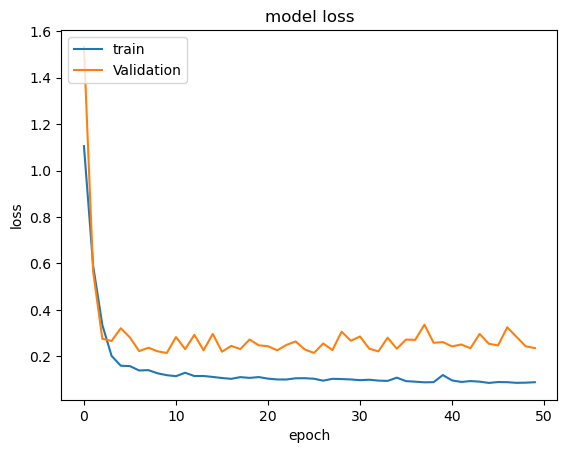

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [9]:
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the GRU model 0.9402782320976257
93/93 [==============================] - 4s 29ms/step


In [10]:
predictions

array([[1.0635019e-06, 1.4994569e-07, 6.7912913e-07, 7.1018692e-03,
        9.9289471e-01, 1.4890508e-06],
       [1.5404735e-06, 9.9120257e-08, 8.5695785e-07, 4.3262090e-03,
        9.9567032e-01, 8.9948981e-07],
       [1.4215860e-06, 1.0515824e-07, 8.0529071e-07, 4.5040292e-03,
        9.9549270e-01, 9.1995247e-07],
       ...,
       [3.7710001e-06, 9.9998033e-01, 5.2043574e-06, 6.3901302e-06,
        2.7692190e-06, 1.4908716e-06],
       [2.9859627e-06, 9.9999022e-01, 1.0153929e-06, 3.4868679e-06,
        1.2328237e-06, 1.0288337e-06],
       [2.7581600e-06, 9.9998891e-01, 7.1170723e-07, 4.3873802e-06,
        1.6210705e-06, 1.5478693e-06]], dtype=float32)

In [11]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[486   1   9   0   0   0]
 [  2 445  23   1   0   0]
 [  1   0 419   0   0   0]
 [  0   0   0 410  74   7]
 [  0   0   0  58 474   0]
 [  0   0   0   0   0 537]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.99      0.98      0.99       496
      Walkup       1.00      0.94      0.97       471
    Walkdown       0.93      1.00      0.96       420
     Sitting       0.87      0.84      0.85       491
    Standing       0.86      0.89      0.88       532
      Laying       0.99      1.00      0.99       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



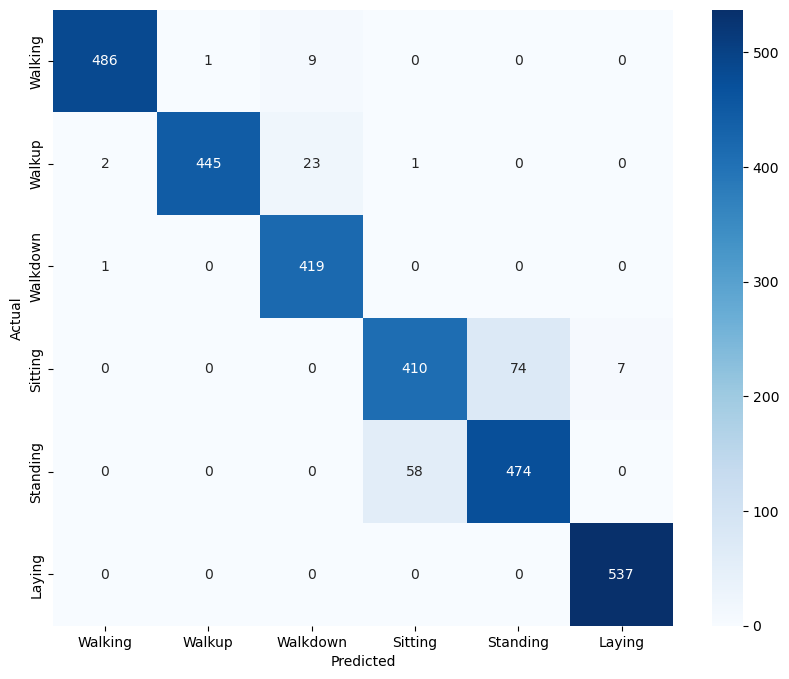

In [12]:
classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(testy,predictions,classNames)